In [3]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn

In [12]:

from IPython.display import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline


The Encoder

In [5]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [6]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Encoder and Decoder implementation

In [7]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [8]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        
        self.eps = eps
    def forward(self, x) :
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean)/(std + self.eps) + self.b_2

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return self.norm(x + self.dropout(sublayer(x)))

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None


In [11]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

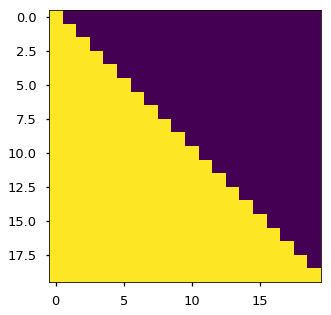

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [13]:
def attention(query, key, value, mask= None, dropout=None):
    d_k = query.size(-1)
  
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    # scores = torch.matmul(query, key)/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    print(p_attn.shape, value.shape)
    a = torch.matmul(p_attn, value)
    return torch.matmul(p_attn, value), p_attn

In [28]:
# x = attention(q, k, v)
k = torch.randn(5, 64, 24)
q = torch.randn(5, 64, 24)
v = torch.randn(5, 64, 24)

lines = clones(nn.Linear(24, 24), 4)

query, key, value = [l(x).view(5, -1, 3, 8).transpose(1,2) for l, x in zip(lines, (q, k, v))]
x, atten = attention(query, key, value)
print(x.shape)
a = x.transpose(1,2)
print(a.shape)
lines[-1](a.contiguous().view(5, -1, 24)[0][0])

torch.Size([5, 3, 64, 64]) torch.Size([5, 3, 64, 8])
torch.Size([5, 3, 64, 8])
torch.Size([5, 64, 3, 8])


tensor([ 4.6194e-06,  4.5589e-02,  2.8807e-01, -2.0720e-01,  1.5754e-01,
        -1.2248e-01,  8.9152e-02,  1.2591e-02,  4.1890e-02, -1.1686e-01,
        -1.9751e-01, -2.2206e-01,  9.5626e-02,  6.8106e-02, -3.8782e-02,
         3.0703e-01, -1.1599e-01,  2.3289e-01,  1.2031e-01,  1.5281e-02,
        -8.2633e-02, -2.3833e-01,  5.5275e-03,  1.9202e-01],
       grad_fn=<ThAddBackward>)

In [31]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        # Actually, the NN.Linear is mapping from d_model to h * d_k
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [41]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        relu_res = F.relu(self.w_1(x))
        print(relu_res)
        return self.w_2(self.dropout(relu_res))

In [42]:
k = torch.randn(5, 64, 24)
q = torch.randn(5, 64, 24)
v = torch.randn(5, 64, 24)

a = MultiHeadedAttention(3, 24)
res = a(q, k, v)
print(res.shape)
print(res[0][0])
ff = PositionwiseFeedForward(24, 64)
print(ff(res[0][0]))

torch.Size([5, 3, 64, 64]) torch.Size([5, 3, 64, 8])
torch.Size([5, 64, 24])
tensor([-0.1161, -0.1371, -0.0631,  0.0147, -0.0827, -0.0352, -0.0950, -0.2493,
        -0.2655,  0.0924, -0.0802, -0.2124, -0.0972,  0.0154,  0.1902,  0.1486,
        -0.1724, -0.2983, -0.1251,  0.1275,  0.0442,  0.0799,  0.0587, -0.1522],
       grad_fn=<SelectBackward>)
tensor([0.1704, 0.0985, 0.1897, 0.2031, 0.2169, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0307, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1984, 0.2026,
        0.1426, 0.0000, 0.0000, 0.0000, 0.1596, 0.1340, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1339, 0.0000, 0.0739, 0.0000, 0.1184, 0.1656, 0.1383,
        0.0000, 0.0000, 0.1392, 0.0000, 0.0000, 0.0000, 0.0000, 0.1339, 0.0928,
        0.0000, 0.0000, 0.0000, 0.0696, 0.0000, 0.0000, 0.0526, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2409, 0.0627, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<ReluBackward>)
tensor([ 0.0159,  0.0456,  0.0589, -0.0717,  0.0

In [13]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [46]:
a = Embeddings(24, 10)
# a('t')

In [11]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

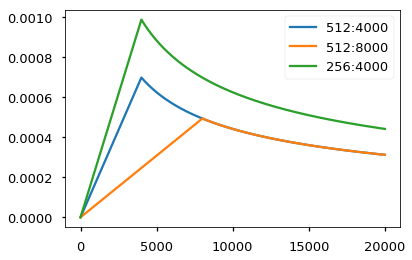

In [12]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [ ]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

In [5]:
from torchtext import data, datasets


import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD='<s>'
EOS_WORD='</s>'
BLANK_WORD="<blank>"

print(tokenize_de("Shuguang Liu"))

SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN= 100

train, val, test = datasets.IWSLT.splits(
    exts = ('.de', '.en'), 
    fields = (SRC, TGT), 
    filter_pred = lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)

MIN_FREQ=2
SRC.build_vocab(train.src, min_freq = MIN_FREQ)
TGT.build_vocab(train.trg, min_freq = MIN_FREQ)

train[0]


['Shuguang', 'Liu']


In [32]:
def run_epoch(dataiter, model):
    for i, batch in enumerate(dataiter):
        print(i)
        dest = batch.trg.transpose(0,1)
        ovec = model(dest)
        print("src-->", dest)
        print("to-->", ovec)
        if (i>10):
            break

In [33]:
#define the transformer
#model = make_model(len(SRC.vocab), len(RGT.vocab), N=6) 
from torchtext.data import Iterator, BucketIterator

BATCHSIZE=5

pad_idx = TGT.vocab.stoi["<blank>"]
train_iter = Iterator(train, batch_size=BATCHSIZE, device=-1, sort=False, sort_within_batch=False,repeat=False)
val_iter = Iterator(val, batch_size=BATCHSIZE, device=-1, sort=False, sort_within_batch=False,repeat=False)


The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [34]:
model = Embeddings(2, len(SRC.vocab))

for epoch in range(1):
    print ("start")
    model.train()
    print("epocstart")
    run_epoch(train_iter,model)
    

start
epocstart
0
src--> tensor([[    2,   362,    65,    16,    14,   778,     5,     3,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [    2, 20782,     4,    12,    73,     7,   177,   216,    11,     6,
           316,    22,    24,  1762,   133,     9,     7,    86,    64,     5,
             3],
        [    2,    32,     4,   435,    15,    43,   232,    40,   116,    47,
            10,  3710,  4070,    10,  1776,   300,     5,     3,     1,     1,
             1],
        [    2,    19,     6,     0,   200,    68,  1129,    11,    26,    35,
            39,  1565,     5,     3,     1,     1,     1,     1,     1,     1,
             1],
        [    2,    58,   140,     7,   365,    46,   675,   877,    11,   106,
             5,     3,     1,     1,     1,     1,     1,     1,     1,     1,
             1]])
to--> tensor([[[-2.9817,  0.8635],
         [-3.0596, -2.3139],
         [-1.7119,  0.9648],
      

         [ 0.1719, -2.3358]]], grad_fn=<MulBackward>)
2
src--> tensor([[    2,   136,    11,   275,    14,    11,    15,    25,     7,    25,
            10,   285,  1174,    56,   648,    24,   587,     5,     3,     1,
             1,     1,     1,     1,     1,     1],
        [    2,    12,   227,    41,  4448,    41,   137,   643,    22,    13,
            10, 10686,  2094,     4,    16,    22,    51,  4094,    30,   137,
           135,     4,    15,    66,    31,     3],
        [    2,    19,  2082,     7,     6,  2703,   724,     4,    40,    11,
          3993,     4,    10,  2483,  1285,   281,   226,    13,     6,   464,
             5,     3,     1,     1,     1,     1],
        [    2,   676,   548,    28,    83,   339,    13,    82,  3688,  1818,
           149,    15,     5,     3,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1],
        [    2,    19,   280,    18,   261,    13,    52,  5873,   464,     5,
             3,   

         [ 0.1719, -2.3358]]], grad_fn=<MulBackward>)
4
src--> tensor([[    2,    88,    35,    77,     6,   728,  1539,     4,     9,    12,
            29,    34,    66,    63,    15,    35,    77,     6,  2735,  2920,
            44,     5,     3,     1,     1,     1,     1,     1],
        [    2,    19,    63,    18,    55,   142,    46,   567,    17,   866,
             8,    20,  1188,     9, 36063,    16,     4,    16,    17,    10,
          2797,   222,     4,   118, 11122,  3495,     5,     3],
        [    2,    32,    18,   474,    39,     7,  1625,     6,   396,    64,
             9,     7, 27471,     6,   823,     5,     3,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,    59,    16,    22,    81,     4,     7,    95,     4,    61,
           199,    41,    10,  1708,     5,     3,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,    19,    16,   101,   39

         [-0.9256,  0.5580]]], grad_fn=<MulBackward>)
6
src--> tensor([[    2,    32,    16,    17,    39,    36,    49,   212,     5,    45,
            17,    39,    36,    82,   212,     5,     3,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [    2,   141,   179,     4,    12,   176,    10,   358,    70,   921,
             5,     3,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [    2,    32,   165,     8,   124,  2776,    27,  3536,     4, 21225,
             9, 14482,    27,  5828,  2078,  5487,     4,     9,     6,  2012,
          5064,    84,  2669,     9,  5886,    11,    70,

         [ 0.1719, -2.3358]]], grad_fn=<MulBackward>)
7
src--> tensor([[    2, 11980,    54,   645,    20,   245,     4,    12,   153,   142,
            10,   225,  1552,     5,     3,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [    2,    12,    90,    67,    64,     7,   129,    64,    24,    95,
             4,     6,   312,     8,    57,   274,     5,    21,     3,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [    2,    32,    16,   919,    47,    10,   182,   212,     5,     3,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [    2,    32,    12,   110,     7,   200,    10,   123,   220,     8,
            10,   152,  1098,     8,    85,    18,    35,   592,   129,    

         [-0.9256,  0.5580]]], grad_fn=<MulBackward>)
9
src--> tensor([[    2,   147,    14,     4,    63,    15,   104,     4,    10, 17743,
             7,   279,     5,     3,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,    12,   204,   129,  1103,     9,   561,   159,    13,   521,
             8,    15,   185,     4,    53,    12,   397,  4012,    50,  2976,
          1765,     9,    22,    13,  1493,  4539,     5,     3],
        [    2,    12,    76,    11,    17,    67,     7,    38,   796,   976,
             5,     3,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,   313,    18,   112,     5,    19,   124,    23,    55,     6,
           595,     5,     3,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,    19,    51,   135,    1

         [ 0.1719, -2.3358]]], grad_fn=<MulBackward>)
11
src--> tensor([[    2,   335,     5,    92,    14,    10,  3767,     8,     6,    96,
          2082,     7,  1892,     5,     3,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1],
        [    2,    92,    14,   108,    18,    43,  3727,    13,   590,     8,
           422,  1331,  5804,     4,     9,    63,    18,   428,    28,    67,
             6,   100,    18,    43,    67,     4,    18,    86,    10, 26344,
            56,   272,    37,  1680,    37, 18480,  1331,  1235,    70,     6,
           240,     8,    20,   534,     5,     3],
        [    2, 14443,    50,    20,   330,     5,     3,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1

         [ 0.1719, -2.3358]]], grad_fn=<MulBackward>)
